In [64]:
from fastai import *          # Quick accesss to most common functionality
from fastai.tabular import *  # Quick accesss to tabular functionality     # Access to example data provided with fastai
path="data"
dfAll = pd.read_csv("data/shuffeled.csv",comment="-") #;df
rowsForTraining = 4000
df=dfAll[0:rowsForTraining]
#print(df)
dep_var = 'journey'
cat_names = ["detectedActivity","weekday"]
cont_names =["geoHash","minuteOfDay"]
procs = [FillMissing, Categorify, Normalize]

In [65]:
test = TabularList.from_df(df.iloc[30:35].copy(), path=path, cat_names=cat_names, cont_names=cont_names)

In [68]:
#test = TabularList.from_df(df.iloc[800:1000].copy(), path=path, cat_names=cat_names, cont_names=cont_names)
#data = TabularDataBunch.from_df(path, df, dep_var, valid_idx=valid_idx, procs=procs, cat_names=cat_names)
#
# tabularList = TabularList.from_df(df, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
# splitList= tabularList.split_by_idx(list(valid_idx))
# splitListLabel=splitList.label_from_df(cols=dep_var)
# splitListLabeltest =splitListLabel.add_test(test, label="MySmallTest") #fastai/data_block.py
# data = splitListLabeltest.databunch()
#Without validation set
print(rowsForTraining-(int(0.1*rowsForTraining)))
#valid_idx = range(rowsForTraining-(int(0.1*rowsForTraining)), rowsForTraining) ##Change
valid_idx = range(3800, rowsForTraining) ##Change
tabularList = TabularList.from_df(df, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
splitList= tabularList.split_by_idx(list(valid_idx))
splitListLabel=splitList.label_from_df(cols=dep_var)
#splitListLabeltest =splitListLabel.add_test(test, label="MySmallTest") #fastai/data_block.py
data = splitListLabel.databunch()

#add_test_folder(self, test_folder:str='test', label:Any=None):
# data = (TabularList.from_df(df, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
#                            .split_by_idx(list(range(800,1000)))
#                            .label_from_df(cols=dep_var)
#                            .add_test(test, label=0)
#                            .databunch())
#print(data.train_ds.cont_names)  # `cont_names` defaults to: set(df)-set(cat_names)-{dep_var}
#print(data.train_ds.cat_names)  # `cont_names` defaults to: set(df)-set(cat_names)-{dep_var}

Total time: 00:00
epoch  train_loss  valid_loss  accuracy
1      0.362900    0.323863    1.000000  (00:00)



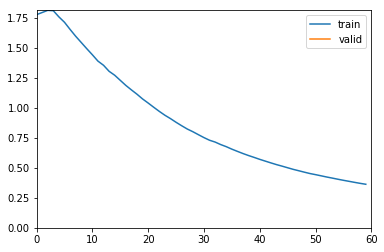

In [69]:
learn = tabular_learner(data, layers=[200,100], metrics=accuracy,callback_fns=ShowGraph)
#learn.fit(3, 1e-2)
learn.fit_one_cycle(1)

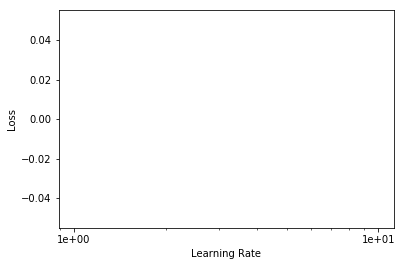

In [6]:
learn.recorder.plot()

In [35]:
%%capture
def predict_journeys(dataset):  
    "Return"
    result = 0
    accuracy = 0
    for x in range(0,dataset.shape[0]):
        correct = dataset.iloc[x].journey  #remove journey
        predicted = learn.predict(dataset.iloc[x],pbar=None);
        if (correct==predicted[0]):
            result=result+1
    #accuracy=result/dataset.size
    accuracy=result/dataset.shape[0]
    return(accuracy)

    
def predict_journey():
    dataset = pd.read_csv("data/shuffNoLabel.csv",comment="-");
    predicted = learn.predict(dataset.iloc[12],pbar=None);
    return(predicted[0],str(round(predicted[2].max().item(),2)))

#orig =df.iloc[300].journey
#print(df.iloc[300])
#print(learn.predict(df.iloc[300]))

In [36]:
%%capture
dataset = pd.read_csv("data/testWithLabels.csv",comment="-")
resultJ = predict_journeys(dataset)

In [37]:
print(resultJ)

1.0


In [10]:
prediction,accuracy = predict_journey()
print(prediction)
print(accuracy)

8121680000
0.96


In [201]:
#predict
#print(learn.predict(df.iloc[30]))
dtest = pd.read_csv("data/shuffNoLabel.csv",comment="-");
predicted = learn.predict(dtest.iloc[1],pbar=None)
print("predicted: " +str(predicted[0])+ " accuracy "+str(100*round(predicted[2].max().item(),2)) +"% correct:"+str(correct))
if(predicted[0]==correct):
    print("yes")

predicted: 8121680140 accuracy 98.0% correct:8121680140
yes


In [197]:
predict_journey()

TypeError: predict_journey() missing 1 required positional argument: 'self'

In [141]:
?? learn.predict

Signature:  learn.predict(img: fastai.core.ItemBase, pbar: Union[fastprogress.fastprogress.MasterBar, fastprogress.fastprogress.ProgressBar, NoneType] = None)
Source:   
    def predict(self, img:ItemBase, pbar:Optional[PBar]=None):
        "Return prect class, label and probabilities for `img`."
        ds = self.data.single_dl.dataset
        ds.set_item(img)
        res = self.pred_batch(ds_type=DatasetType.Single, pbar=pbar)
        ds.clear_item()
        return ds.predict(res)
File:      /opt/anaconda3/lib/python3.7/site-packages/fastai/basic_train.py
Type:      method


In [143]:
#print(data.train_ds.cont_names)  # `cont_names` defaults to: set(df)-set(cat_names)-{dep_var}
#print(data.test_ds.cat_names)  # `cont_names` defaults to: set(df)-set(cat_names)-{dep_var}
data.show_batch(rows=10)

detectedActivity,weekday,geoHash,minuteOfDay,target
3,1,-0.3087,-1.2931,8121680000
3,6,-0.3086,-0.8974,8121690042
7,2,-0.3783,0.1981,8000081216
3,5,-0.3784,1.3006,8014081216
3,3,-0.3783,0.3182,8000081216
3,4,-0.3087,-1.4451,8121680000
7,1,-0.3087,-1.4345,8121680000
7,3,-0.3087,-1.3992,8121680000
3,3,-0.3783,0.1380,8000081216
3,5,-0.3087,-1.3815,8121680000


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


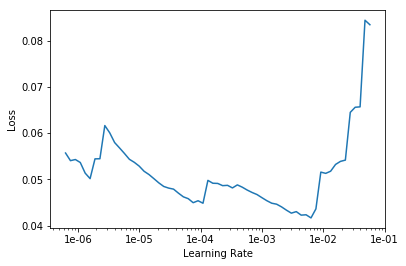

In [144]:
lr_find(learn)
learn.recorder.plot()

In [159]:
(cat_x,cont_x),y = next(iter(data.train_dl))
for o in (cat_x, cont_x, y): print(to_np(o[:5]))

[[3 5]
 [1 5]
 [3 1]
 [3 7]
 [3 5]]
[[-0.308682 -1.360281]
 [-0.308682 -1.388551]
 [ 2.933779  0.703397]
 [-0.30865  -0.886766]
 [-0.378267  0.261685]]
[3 3 5 2 0]


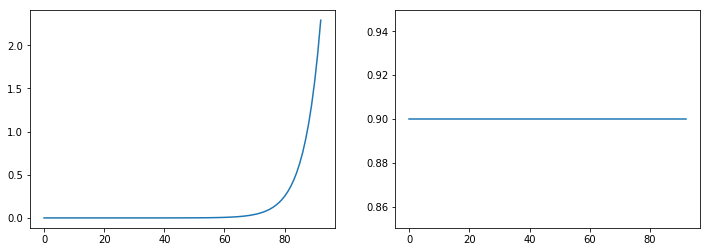

In [64]:
learn.recorder.plot_lr(show_moms=True)

In [80]:
testsetlow = len(df)-1000
randint= random.randrange(testsetlow, len(df))
#df.iloc[3]
print(learn.predict(df.iloc[randint]))
print(df.iloc[randint,4])

(8121680140, tensor(1), tensor([2.6240e-01, 7.3600e-01, 2.4721e-04, 1.5438e-04, 1.4786e-04, 1.0534e-03]))
8000081216


In [66]:
learn.predict(df.iloc[30])

(8121680140,
 tensor(1),
 tensor([2.9488e-05, 9.9988e-01, 1.3241e-06, 1.3889e-06, 4.8722e-05, 4.2089e-05]))

In [64]:
#learn.show_results(df)

In [10]:
cat_sz = [(c, len(df[c].cat.categories)+1) for c in cat_names];cat_sz
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz];emb_szs

AttributeError: Can only use .cat accessor with a 'category' dtype

# Crap